**Table of contents**<a id='toc0_'></a>    
- [Prepare the notebook](#toc1_)    
  - [Import necessary libraries](#toc1_1_)    
  - [Import the datasets](#toc1_2_)    
- [Task 2: Data Transformation](#toc2_)    
  - [Feature engineering and/or novel feature definition](#toc2_1_)    
  - [Outlier detection](#toc2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Prepare the notebook](#toc0_)

## <a id='toc1_1_'></a>[Import necessary libraries](#toc0_)

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install outlier_utils
!pip install plotly

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture

## <a id='toc1_2_'></a>[Import the datasets](#toc0_)

In [2]:
# Load the dataset
df_races = pd.read_csv('dataset/races.csv')
df_cyclists = pd.read_csv('dataset/cyclists.csv')

# <a id='toc2_'></a>[Task 2: Data Transformation](#toc0_)

## <a id='toc2_1_'></a>[Feature engineering and/or novel feature definition](#toc0_)

In [ ]:
df_imputed = df_cyclists.copy()

# Identify rows with missing values
missing_before = df_imputed[df_imputed[['weight', 'height']].isnull().any(axis=1)]

imputer = SimpleImputer(strategy='mean')

df_imputed[['weight', 'height']] = imputer.fit_transform(df_imputed[['weight', 'height']])

# Identify rows that had missing values before but are now imputed
imputed_rows = df_imputed.loc[missing_before.index]

# Display (only) the imputed rows
print(imputed_rows)


In [ ]:
df_imputed = df_cyclists.copy()

columns_to_impute = ['weight', 'height']

imputer = KNNImputer(n_neighbors=3)

df_imputed[columns_to_impute] = imputer.fit_transform(df_imputed[columns_to_impute])

# Identify rows with missing values
missing_before = df_cyclists[df_cyclists[columns_to_impute].isnull().any(axis=1)]
imputed_rows = df_imputed.loc[missing_before.index]

# Display the imputed rows from the new dataframe
print("Imputed Rows:\n", imputed_rows)

In [ ]:
# Maybe we can try KNNImputer while including the birthyear and encoding the country as a number?
# one-hot encoding makes sense for the nationality to avoid ordinal relationships between countries.
from sklearn.preprocessing import OneHotEncoder

df_imputed = df_cyclists.copy()

# 1. One-Hot Encode 'nationality' to include it in the imputation process
encoder = OneHotEncoder(sparse=False, drop='first')  # Drop first to avoid multicollinearity
nationality_encoded = encoder.fit_transform(df_cyclists[['nationality']])
nationality_encoded_df = pd.DataFrame(nationality_encoded, columns=encoder.get_feature_names_out(['nationality']))

# print(nationality_encoded_df.iloc[0])

df_impute_data = pd.concat([df_cyclists[['birth_year', 'weight', 'height']], nationality_encoded_df], axis=1)

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=10)

# Perform the imputation
df_imputed_values = pd.DataFrame(imputer.fit_transform(df_impute_data), columns=df_impute_data.columns)

# Replace the imputed weight and height back into the original DataFrame copy
df_final = df_cyclists.copy()
df_final[['weight', 'height']] = df_imputed_values[['weight', 'height']]

# Identify the rows that had missing values before the imputation
columns_to_impute = ['weight', 'height']
missing_before = df_cyclists[df_cyclists[columns_to_impute].isnull().any(axis=1)]

# Display the imputed rows with the full cyclist information
imputed_rows = df_final.loc[missing_before.index]

# Display the imputed rows (with full cyclist information)
print("Imputed Rows:\n", imputed_rows)

In [ ]:
# Cyclist heights

plt.figure(figsize=(10, 6))

sns.histplot(imputed_rows['height'].dropna(), kde=False, bins=200, color='blue')

plt.title('Distribution of heights of cyclists', fontsize=16)
plt.xlabel('Height', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

In [ ]:


df_imputed = df_cyclists.copy()

columns_to_impute = ['birth_year']

imputer = KNNImputer(n_neighbors=3)

df_imputed[columns_to_impute] = imputer.fit_transform(df_imputed[columns_to_impute])

# Identify rows with missing values
missing_before = df_cyclists[df_cyclists[columns_to_impute].isnull().any(axis=1)]
imputed_rows = df_imputed.loc[missing_before.index]

# Display the imputed rows from the new dataframe
print("Imputed Rows:\n", imputed_rows)

## <a id='toc2_2_'></a>[Outlier detection](#toc0_)

In [9]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100)

In [ ]:
def plot_iqr_outliers(df: pd.DataFrame, columns: list, columns_per_row=2):
    """
    Detect outliers using the IQR method, add outlier indicators to the DataFrame,
    and plot boxplots for multiple columns.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to check for outliers and plot boxplots.
        columns_per_row (int): Number of columns per row for the grid layout (default: 2).
    
    Returns:
        tuple: Modified DataFrame with outlier indicators and a dictionary with IQR test results for each column.
    """
    outliers = {}
    overall_outliers = pd.Series(False, index=df.index)
    
    num_cols = len(columns)
    num_rows = (num_cols + columns_per_row - 1) // columns_per_row
    
    # Create the grid of subplots
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    for i, col in enumerate(columns):
        if col not in df.columns:
            print(f"Column {col} does not exist in the DataFrame.")
            continue

        # Filter out NaN values for calculations
        col_data = df[col].dropna()
        
        # Calculate Q1, Q3, and IQR
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers in this column
        col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        df[f"iqr_outlier_{col}"] = col_outliers
        overall_outliers |= col_outliers  # Update the overall outlier flag
        
        # Store outlier information in the results dictionary
        outliers[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outliers': df.loc[col_outliers, col].tolist()
        }

        # Plot the data using a boxplot
        sns.boxplot(x=col_data, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col} with IQR Outliers')
        axes[i].set_xlabel(f'Values in {col}')

        print(f"Number of outliers in {col}: {len(outliers[col]['outliers'])}")
    
    # Remove unused subplots if the number of columns is not a perfect multiple of columns_per_row
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
    # Add the overall outlier flag to the DataFrame
    df["iqr_outlier"] = overall_outliers

    return df, outliers

# Specify the columns to check
columns_to_check = ['uci_points', 'points', 'length', 'climb_total', 'average_temperature', 'position', 'cyclist_age', 'delta']

# Detect outliers using the IQR method and plot boxplots
df_with_outliers_unused, outliers = plot_iqr_outliers(df_races, columns_to_check, columns_per_row=2)

print(df_with_outliers_unused)

# Specify the columns to check
columns_to_check = ['birth_year', 'height', 'weight']

# Detect outliers using the IQR method and plot boxplots
outliers = plot_iqr_outliers(df_cyclists, columns_to_check, columns_per_row=2)


Let's generate histograms to do a quick check for which columns might be normally distributed

In [ ]:
def plot_histograms(df, columns_per_row=2):
    # Select only numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols = len(numerical_cols)
    
    # Calculate the number of rows required based on the number of columns per row
    num_rows = (num_cols + columns_per_row - 1) // columns_per_row
    
    # Set up the figure with a grid of subplots
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5 * num_rows))
    
    # Flatten the axes array in case of multiple rows
    axes = axes.flatten()
    
    # Plot each column
    for i, col in enumerate(numerical_cols):
        axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(f"Histogram of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    # Remove any unused subplots if the number of columns is not a perfect multiple of columns_per_row
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

plot_histograms(df_cyclists)
plot_histograms(df_races)


Let's generate some Q-Q plots to determine which columns are likely normally distributed

In [ ]:
def generate_qq_plots(df, columns_per_row=2):
    # Select numerical columns in the dataframe
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_cols = len(numerical_cols)
    
    # Calculate the number of rows needed based on the number of columns per row
    num_rows = (num_cols + columns_per_row - 1) // columns_per_row
    
    # Set up the figure with a grid of subplots
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5 * num_rows))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Plot Q-Q plots for each numerical column
    for i, col in enumerate(numerical_cols):
        stats.probplot(df[col].dropna(), dist="norm", plot=axes[i])
        axes[i].set_title(f"Q-Q Plot for {col}")
    
    # Remove any unused subplots if the number of columns is not a perfect multiple of columns_per_row
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Generate Q-Q plots for each df
generate_qq_plots(df_races)
generate_qq_plots(df_cyclists)


In [ ]:
from scipy.stats import normaltest

# Apply the D'Agostino-Pearson test
stat, p_value = normaltest(df_cyclists['weight'].dropna())

if p_value > 0.05:
    print(f"Height: Normally distributed (p-value = {p_value:.4f})")
else:
    print(f"Height: Not normally distributed (p-value = {p_value:.4f})")

For normally distributed variables, we can use Grubb's test

In [ ]:
from scipy.stats import t

# Logic for test taken from Method 3 here: https://blog.finxter.com/5-best-ways-to-perform-grubbs-test-in-python/
# This also helps to understand: https://github.com/bhattbhavesh91/outlier-detection-grubbs-test-and-generalized-esd-test-python/blob/master/grubbs-test-for-outliers.ipynb

def grubbs_test(df, columns, alpha=0.05):
    """
    Perform Grubbs' test on the specified columns of a DataFrame and add outlier indicators.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to apply Grubbs' test.
        alpha (float): The significance level (default: 0.05).
    
    Returns:
        tuple: Modified DataFrame with outlier indicators and a dictionary with Grubbs' test results for each column.
    """
    results = {}
    overall_outliers = pd.Series(False, index=df.index)

    # Loop through each column specified for the test
    for col in columns:
        if col not in df.columns:
            print(f"Column {col} does not exist in the DataFrame.")
            continue

        data = df[col].dropna().values  # Drop any missing values
        N = len(data)

        if N < 3:  # Ensure there's enough data to run the test
            print(f"Not enough data points in {col} to run Grubbs' test.")
            continue

        # Calculate mean and standard deviation
        mean = np.mean(data)
        std_dev = np.std(data, ddof=1)

        # Grubbs' test statistic
        G_calculated = max(abs(data - mean)) / std_dev

        # Critical value for Grubbs' test
        t_critical = t.isf(alpha / (2 * N), N - 2)
        G_critical = ((N - 1) / np.sqrt(N)) * np.sqrt(t_critical**2 / (N - 2 + t_critical**2))

        # Identify outliers in this column
        col_outliers = abs(df[col] - mean) / std_dev > G_critical
        df[f"grubbs_outlier_{col}"] = col_outliers

        # Update the overall outliers
        overall_outliers |= col_outliers

        # Store results for this column
        results[col] = {
            'G_calculated': G_calculated,
            'G_critical': G_critical,
            'outlier_detected': G_calculated > G_critical
        }

    # Add the overall outlier flag to the DataFrame
    df["grubbs_outlier"] = overall_outliers

    return df, results

columns_to_check = ['height', 'weight']
df_with_outliers_unused, grubbs_results = grubbs_test(df_cyclists, columns_to_check, alpha=0.05)

outlier_rows = df_with_outliers_unused[df_with_outliers_unused["grubbs_outlier"] == True]
print(outlier_rows)

for col, res in grubbs_results.items():
    print(f"Column: {col}")
    print(f"  G_calculated: {res['G_calculated']:.4f}")
    print(f"  G_critical: {res['G_critical']:.4f}")
    print(f"  Outlier detected: {res['outlier_detected']}\n")


For non-normal columns, we can use Chebyshev's Inequality (better than Markov's inequality because we know the variance)

In [ ]:
def chebyshev_outliers(df, columns, k=3):
    """
    Detect outliers using Chebyshev's inequality on the specified columns of a DataFrame
    and add outlier indicators to the DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to apply Chebyshev's inequality.
        k (float): The number of standard deviations to check for outliers (default: 3).
    
    Returns:
        tuple: Modified DataFrame with outlier indicators and a dictionary with Chebyshev test results for each column.
    """
    outliers = {}
    overall_outliers = pd.Series(False, index=df.index)

    for col in columns:
        if col not in df.columns:
            print(f"Column {col} does not exist in the DataFrame.")
            continue

        data = df[col].dropna().values  # Drop any missing values
        mean = np.mean(data)
        std_dev = np.std(data, ddof=1)

        # Chebyshev's inequality bounds
        lower_bound = mean - k * std_dev
        upper_bound = mean + k * std_dev

        # Identify outliers in this column
        col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        df[f"chebyshev_outlier_{col}"] = col_outliers

        # Update the overall outliers
        overall_outliers |= col_outliers

        # Store results for this column
        outliers[col] = {
            'mean': mean,
            'std_dev': std_dev,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outliers': df.loc[col_outliers, col].tolist()
        }

    # Add the overall outlier flag to the DataFrame
    df["chebyshev_outlier"] = overall_outliers

    return df, outliers

columns_to_check = ['birth_year']
df_with_outliers_unused, chebyshev_results = chebyshev_outliers(df_cyclists, columns_to_check, k=3)

for col, res in chebyshev_results.items():
    print(f"Column: {col}")
    print(f"  Mean: {res['mean']:.4f}")
    print(f"  Std Dev: {res['std_dev']:.4f}")
    print(f"  Lower Bound: {res['lower_bound']:.4f}")
    print(f"  Upper Bound: {res['upper_bound']:.4f}")
    print(f"  Outliers: {res['outliers']}\n")

columns_to_check = ['uci_points', 'points', 'length', 'climb_total', 'average_temperature', 'position', 'cyclist_age', 'delta']
df_with_outliers_unused, chebyshev_results = chebyshev_outliers(df_races, columns_to_check, k=3)

outlier_rows = df_with_outliers_unused[df_with_outliers_unused["chebyshev_outlier"] == True]
print(outlier_rows)

for col, res in chebyshev_results.items():
    print(f"Column: {col}")
    print(f"  Mean: {res['mean']:.4f}")
    print(f"  Std Dev: {res['std_dev']:.4f}")
    print(f"  Lower Bound: {res['lower_bound']:.4f}")
    print(f"  Upper Bound: {res['upper_bound']:.4f}")
    print(f"  Outliers: {res['outliers']}\n")


# PCA

In [3]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to multiple lines

def pca_outlier_contribution_and_plot_3d(df, columns, n_components=3, threshold=2.5):
    """
    Perform PCA-based outlier detection and return a DataFrame with outlier information.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): A list of column names to apply PCA outlier detection.
        n_components (int): Number of principal components to use (default: 3).
        threshold (float): The reconstruction error threshold for identifying outliers (default: 2.5).
    
    Returns:
        pd.DataFrame: Modified DataFrame with reconstruction error and outlier flag.
    """
    # Ensure only the specified columns are selected
    df_numerical = df[columns]
    
    # Drop rows with missing values (NaN) in the selected columns
    df_numerical_cleaned = df_numerical.dropna()
    
    # Standardize the numerical data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_numerical_cleaned)
    
    # Apply PCA to reduce the dimensionality of the numerical data
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Reconstruct the data from the principal components
    X_reconstructed = pca.inverse_transform(X_pca)
    
    # Compute the reconstruction error for each feature (column-wise error)
    column_wise_error = (X_scaled - X_reconstructed) ** 2  # Error for each column
    
    # Compute the overall reconstruction error (sum across columns)
    reconstruction_error = np.sum(column_wise_error, axis=1)
    
    # Flag points with high overall reconstruction error as outliers
    outliers = reconstruction_error > threshold
    
    # Create a copy of the original DataFrame to store outlier information
    df_copy = df.loc[df_numerical_cleaned.index].copy()  # Only keep rows without missing values
    
    # Add the reconstruction error and outlier flag to the copy of the DataFrame
    df_copy['reconstruction_error'] = reconstruction_error
    df_copy['pca_outlier'] = outliers
    
    # Compute and display PCA loadings (weights of each feature on each principal component)
    loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(n_components)], index=columns)
    
    # Show the loadings
    print("PCA Loadings (weights of each feature on the principal components):")
    print(loadings)
    
    # Create a 3D interactive plot using Plotly
    fig = px.scatter_3d(
        x=X_pca[:, 0],  # Principal Component 1
        y=X_pca[:, 1],  # Principal Component 2
        z=X_pca[:, 2],  # Principal Component 3
        title='3D PCA Manifold with Outliers',
        labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'},
        opacity=0.7,
    )
    
    fig.update_traces(marker=dict(size=5))
    fig.show()
    
    # If a row is an outlier, find which columns contributed most to the error
    contribution = pd.DataFrame(column_wise_error, columns=df_numerical_cleaned.columns, index=df_numerical_cleaned.index)
    
    # Return DataFrame with outlier information and column-wise contributions
    return df_copy, contribution, loadings

selected_columns = ['points', 'uci_points', 'length', 'climb_total', 'profile', 'startlist_quality', 'average_temperature', 'cyclist_age']  # Exclude 'position' and any irrelevant columns
df_with_outliers, contribution_df, loadings_df = pca_outlier_contribution_and_plot_3d(df_races, selected_columns, n_components=3, threshold=15)

# Display outliers with their overall reconstruction error
print(df_with_outliers[df_with_outliers['pca_outlier']])

# Display contribution of each column for the outlier rows
outliers_contributions = contribution_df.loc[df_with_outliers[df_with_outliers['pca_outlier']].index]
print(outliers_contributions)

# Show the loadings (weights of each feature on each principal component)
print(loadings_df)

# Drop the reconstruction_error column since we don't want it from now on
df_with_outliers.drop('reconstruction_error', axis=1, inplace=True)


PCA Loadings (weights of each feature on the principal components):
                          PC1       PC2       PC3
points               0.604008 -0.154843  0.001388
uci_points           0.599581 -0.159351 -0.041082
length               0.424460  0.142464 -0.072864
climb_total          0.198540  0.680754 -0.013191
profile             -0.020687  0.679473  0.094213
startlist_quality    0.199456 -0.007562  0.674588
average_temperature -0.122046 -0.071144  0.681792
cyclist_age          0.031408  0.010352  0.253067


                                  _url               name  points  uci_points   length  climb_total  profile  startlist_quality  average_temperature                 date  position                   cyclist  cyclist_age  is_tarmac  is_cobbled  is_gravel                          cyclist_team  delta  reconstruction_error  pca_outlier
41561         gran-camino/2023/stage-4      O Gran Camiño    20.0        14.0  18100.0        308.0      2.0                156                 11.0  2023-02-26 00:28:54       111          david-livramento         40.0       True       False      False       liberty-seguros-wurth-team-2005  307.0             15.613165         True
139959  tirreno-adriatico/2023/stage-1  Tirreno-Adriatico    50.0        60.0  11500.0          3.0      1.0               1044                 13.0  2023-03-06 00:13:42        45            dries-devenyns         40.0       True       False      False               csf-group-navigare-2008   74.0             16.019187         True
2

# Distributional approach

In [4]:
def gmm_test(df):
    # Select only numeric columns from df
    numeric_columns = df.select_dtypes(include="number")
    numeric_data = numeric_columns.dropna()  # Drop rows with missing numeric values. Consider imputation if needed.

    # Fit the Gaussian Mixture Model to the numeric data
    k = 5
    algorithm = GaussianMixture(n_components=k, random_state=42)
    algorithm.fit(numeric_data.values)

    # Predict probabilities and compute outlier scores
    outlier_degrees_per_normal = algorithm.predict_proba(numeric_data.values)
    outlier_degrees = outlier_degrees_per_normal.max(axis=1)  # Higher values indicate more normal, lower values more likely outlier

    # Create DataFrame of outlier degrees
    outlier_scores_df = pd.DataFrame(outlier_degrees, index=numeric_data.index, columns=["density_degree"])

    # Define threshold (e.g., below the 5th percentile could be outliers)
    threshold = outlier_scores_df["density_degree"].quantile(0.05)
    outlier_series = pd.Series(False, index=df.index)
    outlier_series[numeric_data.index] = outlier_scores_df["density_degree"] < threshold

    # Merge the outlier degree and boolean outlier column back into the original DataFrame
    df["density_degree"] = outlier_scores_df["density_degree"]
    df["gmm_outlier"] = outlier_series

    # Sort the DataFrame by "density_degree" in ascending order for review
    df_sorted = df.sort_values(by="density_degree", ascending=True)

    # Plot sorted outlier degrees
    sorted_outlier_degrees = sorted(outlier_degrees)
    sns.lineplot(
        x=range(len(sorted_outlier_degrees)),
        y=sorted_outlier_degrees
    )

    # Return the modified DataFrame
    return df_sorted


                                  _url                        name  points  uci_points    length  climb_total  profile  startlist_quality  average_temperature                 date  ...            cyclist cyclist_age  is_tarmac  is_cobbled  is_gravel                          cyclist_team  delta  pca_outlier  density_degree  gmm_outlier
168114      giro-d-italia/2022/stage-6               Giro d'Italia    80.0       100.0  192000.0       1498.0      2.0                817                 21.0  2022-05-12 05:02:33  ...     michael-morkov        37.0       True       False      False                       kazakhstan-2001    0.0        False        0.501997         True
168110      giro-d-italia/2022/stage-6               Giro d'Italia    80.0       100.0  192000.0       1498.0      2.0                817                 21.0  2022-05-12 05:02:33  ...    lawrence-naesen        30.0       True       False      False                           mexico-1986    0.0        False        0.502298   

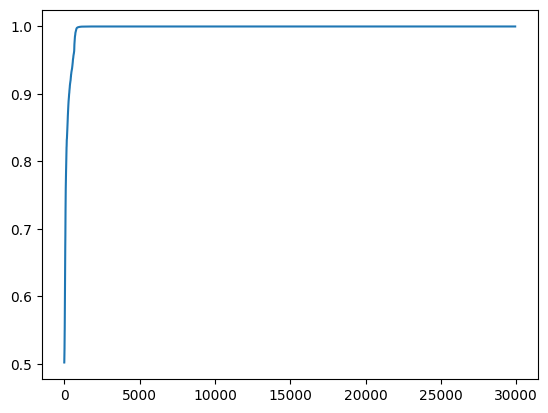

In [5]:
df_with_outliers = gmm_test(df_with_outliers)

outlier_rows = df_with_outliers[df_with_outliers["gmm_outlier"] == True]
print(outlier_rows)

# Drop the density degree column since we don't want it from now on
df_with_outliers.drop('density_degree', axis=1, inplace=True)

# Connectivity approach

In [6]:
def connectivity_approach(df):
    import seaborn as sns
    from sklearn.neighbors import LocalOutlierFactor

    # Select only numeric columns from df
    numeric_columns = df.select_dtypes(include="number")
    numeric_data = numeric_columns.dropna()  # Drop rows with missing numeric values. Consider imputation if needed.

    # Initialize the Local Outlier Factor model
    k = 25
    algorithm = LocalOutlierFactor(n_neighbors=k)

    # Fit the model and predict outliers only on the rows without missing values
    outlier_predictions = algorithm.fit_predict(numeric_data)

    # Create a Series with the same index as the original DataFrame, defaulting to False
    outlier_series = pd.Series(False, index=df.index)

    # Assign True where the rows are outliers
    outlier_series[numeric_data.index] = (outlier_predictions == -1)

    # Add the "connectivity_approach" column to the original DataFrame
    df["connectivity_approach_outlier"] = outlier_series

    # Negated outlier scores: the higher, the more of an outlier
    outlier_degrees = -algorithm.negative_outlier_factor_
    sorted_outlier_degrees = sorted(outlier_degrees)

    # to achieve comparable degrees among different algorithms,
    # we normalize distance-based scores by the maximum possible distance
    # distances = squareform(pdist(data_only_dataset.values))
    # maximum_possible_radius = distances.max()
    # normalization_factor = maximum_possible_radius / k
    # normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
    # dataset_with_outlier_scores.loc[:, "lof_degree_normalized"] = outlier_degrees / normalization_factor

    # Plot the sorted outlier degrees
    sns.lineplot(
        x=range(len(sorted_outlier_degrees)),
        y=sorted_outlier_degrees
    )

    # Return the modified DataFrame
    return df

                                       _url                         name  points  uci_points    length  climb_total  profile  startlist_quality  average_temperature                 date  ...              cyclist cyclist_age  is_tarmac  is_cobbled  is_gravel                      cyclist_team   delta  pca_outlier  gmm_outlier  connectivity_approach_outlier
368236          giro-d-italia/2023/stage-20                Giro d'Italia    80.0       180.0   18600.0       1070.0      5.0                835                 18.0  2023-05-27 00:56:28  ...       mark-cavendish        38.0       True       False      False                  watney-avia-1972   725.0         True         True                           True
368237          giro-d-italia/2023/stage-20                Giro d'Italia    80.0       180.0   18600.0       1070.0      5.0                835                 18.0  2023-05-27 00:56:29  ...           max-kanter        26.0       True       False      False                united-states

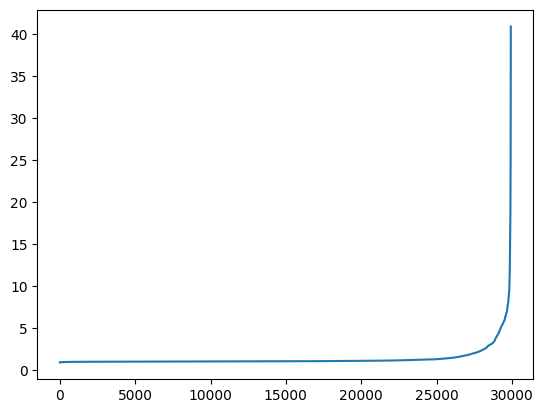

In [7]:
df_with_outliers = connectivity_approach(df_with_outliers)

outlier_rows = df_with_outliers[df_with_outliers["connectivity_approach_outlier"] == True]
print(outlier_rows)

# One-class SVM

In [8]:
def one_class_svm(df):
    from sklearn.svm import OneClassSVM

    # Select only numeric columns from df
    numeric_columns = df.select_dtypes(include="number")
    numeric_data = numeric_columns.dropna()  # Drop rows with missing numeric values. Consider imputation if needed.

    # Initialize the OneClassSVM model
    kernel = "rbf"
    algorithm = OneClassSVM(kernel=kernel)
    algorithm.fit(numeric_data)

    # Predict outliers: +1 for inliers, -1 for outliers
    outlier_classification_scores = algorithm.predict(numeric_data)
    outlier_distance_scores = algorithm.score_samples(numeric_data)

    # Add distance scores to the corresponding rows in the original DataFrame
    df.loc[numeric_data.index, "oneclass_svm_degree"] = outlier_distance_scores

    # Map outlier classification scores to a boolean column: True for outliers, False for inliers
    outlier_series = pd.Series(False, index=df.index)
    outlier_series[numeric_data.index] = (outlier_classification_scores == -1)
    df["oneclass_svm_outlier"] = outlier_series

    # If kernel is linear, retrieve support vectors
    support_vectors = numeric_data.iloc[algorithm.support_] if kernel == "linear" else None

    # Plot sorted outlier degrees
    sorted_outlier_degrees = sorted(outlier_distance_scores)
    sns.lineplot(
        x=range(len(sorted_outlier_degrees)),
        y=sorted_outlier_degrees
    )

    # Return the modified DataFrame
    return df

                               _url           name  points  uci_points    length  climb_total  profile  startlist_quality  average_temperature                 date  ...  is_tarmac is_cobbled  is_gravel                          cyclist_team   delta  pca_outlier gmm_outlier  connectivity_approach_outlier  oneclass_svm_degree  oneclass_svm_outlier
368236  giro-d-italia/2023/stage-20  Giro d'Italia    80.0       180.0   18600.0       1070.0      5.0                835                 18.0  2023-05-27 00:56:28  ...       True      False      False                      watney-avia-1972   725.0         True        True                           True          6903.247357                  True
114285  giro-d-italia/2022/stage-11  Giro d'Italia    80.0       100.0  203000.0        369.0      1.0                817                 26.0  2022-05-18 04:19:04  ...       True      False      False                            japan-2008     0.0        False        True                          False   

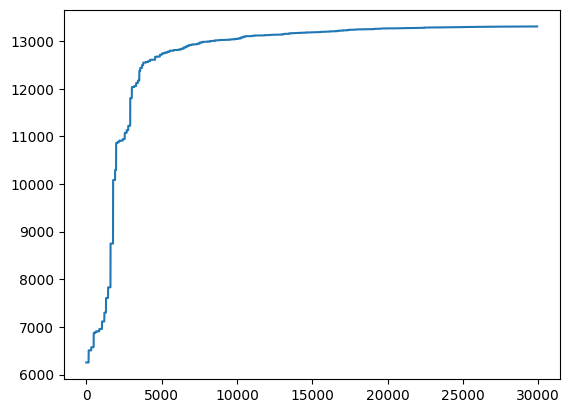

In [9]:
df_with_outliers = one_class_svm(df_with_outliers)

outlier_rows = df_with_outliers[df_with_outliers["oneclass_svm_outlier"] == True]
print(outlier_rows)

# Drop the oneclass_svm_degree column since we don't want it from now on
df_with_outliers.drop('oneclass_svm_degree', axis=1, inplace=True)

# Isolation forest

In [10]:
def isolation_forest(df):
    import pandas as pd
    import seaborn as sns
    from sklearn.ensemble import IsolationForest

    # Select only numeric columns from df
    numeric_columns = df.select_dtypes(include="number")
    numeric_data = numeric_columns.dropna()  # Drop rows with missing numeric values. Consider imputation if needed.

    # Initialize the Isolation Forest model
    max_features = numeric_data.shape[1]  # Use the number of features in the numeric data
    algorithm = IsolationForest(max_features=max_features)
    algorithm.fit(numeric_data)

    # Calculate outlier degrees and scores
    outlier_degrees = algorithm.decision_function(numeric_data) + 0.5
    outlier_scores = 1 - (algorithm.predict(numeric_data) + 1) / 2  # 1 for outliers, 0 for inliers

    # Assign degrees and scores to the corresponding rows in the original DataFrame
    df.loc[numeric_data.index, "isolation_forest_degree"] = outlier_degrees
    df.loc[numeric_data.index, "isolation_forest_scores"] = outlier_scores

    # Create a boolean column for outlier identification
    outlier_series = pd.Series(False, index=df.index)
    outlier_series[numeric_data.index] = (outlier_scores == 1)
    df["isolation_forest_outlier"] = outlier_series

    # Plot sorted outlier degrees
    sorted_outlier_degrees = sorted(outlier_degrees)
    sns.lineplot(
        x=range(len(sorted_outlier_degrees)),
        y=sorted_outlier_degrees
    )

    # Return the modified DataFrame
    return df

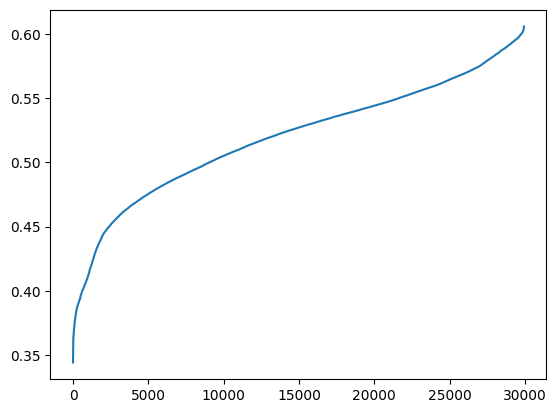

In [11]:
df_with_outliers = isolation_forest(df_with_outliers)

outlier_rows = df_with_outliers[df_with_outliers["isolation_forest_outlier"] == True]
outlier_rows

# Drop the oneclass_svm_degree column since we don't want it from now on
df_with_outliers.drop('isolation_forest_degree', axis=1, inplace=True)
df_with_outliers.drop('isolation_forest_scores', axis=1, inplace=True)

## Get the final list of 'outlier' columns get getting the columns that were identified by a majority of tests

In [14]:
# List of columns to check
outlier_columns = [
    'isolation_forest_outlier', 
    'oneclass_svm_outlier', 
    'connectivity_approach_outlier', 
    'gmm_outlier', 
    'pca_outlier'
]

# Select rows where at least 3 out of the 5 specified columns are True
df_selected = df_with_outliers[df_with_outliers[outlier_columns].sum(axis=1) >= 3]

df_selected



# Or to drop the rows
# rows_to_drop = df_with_outliers[outlier_columns].sum(axis=1) >= 3

# Drop these rows from the DataFrame
# df_without_outliers = df_with_outliers[~rows_to_drop]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,...,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,pca_outlier,gmm_outlier,connectivity_approach_outlier,oneclass_svm_outlier,isolation_forest_outlier
368236,giro-d-italia/2023/stage-20,Giro d'Italia,80.0,180.0,18600.0,1070.0,5.0,835,18.0,2023-05-27 00:56:28,...,True,False,False,watney-avia-1972,725.0,True,True,True,True,True
368237,giro-d-italia/2023/stage-20,Giro d'Italia,80.0,180.0,18600.0,1070.0,5.0,835,18.0,2023-05-27 00:56:29,...,True,False,False,united-states-1998,726.0,False,True,True,True,True
368134,giro-d-italia/2023/stage-20,Giro d'Italia,80.0,180.0,18600.0,1070.0,5.0,835,18.0,2023-05-27 00:47:11,...,True,False,False,kazakhstan-2019,168.0,False,True,False,True,True
368133,giro-d-italia/2023/stage-20,Giro d'Italia,80.0,180.0,18600.0,1070.0,5.0,835,18.0,2023-05-27 00:47:07,...,True,False,False,teka-1988,164.0,False,True,False,True,True
368135,giro-d-italia/2023/stage-20,Giro d'Italia,80.0,180.0,18600.0,1070.0,5.0,835,18.0,2023-05-27 00:47:26,...,True,False,False,bankgiroloterij-batavus-2000,183.0,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219397,san-sebastian/2022/result,Donostia San Sebastian Klasikoa,225.0,400.0,224800.0,4147.0,2.0,724,23.0,2022-07-30 05:43:54,...,False,False,False,new-zealand-2020,730.0,False,False,True,True,True
219398,san-sebastian/2022/result,Donostia San Sebastian Klasikoa,225.0,400.0,224800.0,4147.0,2.0,724,23.0,2022-07-30 05:43:54,...,False,False,False,denmark-2016,730.0,False,False,True,True,True
219401,san-sebastian/2022/result,Donostia San Sebastian Klasikoa,225.0,400.0,224800.0,4147.0,2.0,724,23.0,2022-07-30 05:45:32,...,False,False,False,kazakhstan-2022,828.0,False,False,True,True,True
219400,san-sebastian/2022/result,Donostia San Sebastian Klasikoa,225.0,400.0,224800.0,4147.0,2.0,724,23.0,2022-07-30 05:45:25,...,False,False,False,sem-france-loire-1982,821.0,False,False,True,True,True
